In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from math import isnan

In [12]:
def get_ellipse_bounding_box(x, y, z, major, medium, minor, azimuth, dip):
    """
    x,y : coordinate of center of ellpise
    major : vario_range along long axis
    minor : vario_range along short axis
    
    Hypothesis of major and medium axis to define horizontal plan and major / minor to define vertical plan
    
    azimuth : angle of major axis with east axis, positive clockwise, i.e. to the north direction, From 0 to 360
    
    dip : angle with the major axis, negative to the center of earth, From -90 to 90
    
    Compute tight ellipse bounding box.

    https://gist.github.com/smidm/b398312a13f60c24449a2c7533877dc0

    see https://stackoverflow.com/questions/87734/how-do-you-calculate-the-axis-aligned-bounding-box-of-an-ellipse#88020
    """
    
    azimuth = -azimuth
    
    t = np.arctan(-medium * np.tan(azimuth) / (major))
    
    if np.tan(dip) == 0:
        q = np.pi/2
    else :
        q = np.arctan(minor / np.tan(dip) / (major))
        
        
    if (azimuth >= 0 * np.pi/180 and azimuth <= 45 * np.pi/180) or (azimuth >= 135 * np.pi/180 and azimuth <= 225 *np.pi/180)  or (azimuth >= 315 * np.pi/180 and azimuth <= 360 *np.pi/180) :
        print("Major axis along x")
        
        [min_y, max_y] = np.sort([y + major * np.cos(t) * np.cos(azimuth) -
                          medium * np.sin(t) * np.sin(azimuth) for t in (t, t + np.pi)])

        if np.tan(azimuth) == 0:
            t = np.pi/2
        else :
            t = np.arctan(minor / np.tan(azimuth) / (major))

        [min_x, max_x] = np.sort([x + medium * np.sin(t) * np.cos(azimuth) +
                          major * np.cos(t) * np.sin(azimuth) for t in (t, t + np.pi)])
        
        [min_z, max_z] = np.sort([z + minor * np.sin(q) * np.cos(dip) +
                      major * np.cos(q) * np.sin(dip) for q in (q, q + np.pi)])
        
        
        
    else :
        print("Major axis along y")
        [min_x, max_x] = np.sort([x + major * np.cos(t) * np.cos(azimuth) -
                          medium * np.sin(t) * np.sin(azimuth) for t in (t, t + np.pi)])

        if np.tan(azimuth) == 0:
            t = np.pi/2
        else :
            t = np.arctan(medium / np.tan(azimuth) / (major))

        [min_y, max_y] = np.sort([y + medium * np.sin(t) * np.cos(azimuth) +
                          major * np.cos(t) * np.sin(azimuth) for t in (t, t + np.pi)])
    
        [min_z, max_z] = np.sort([z + minor * np.sin(q) * np.cos(dip) +
                      major * np.cos(q) * np.sin(dip) for q in (q, q + np.pi)])
        
        
    
    return round(min_x), round(min_y), round(min_z), round(max_x), round(max_y),round(max_z)



def extract_feflow_from_ellipsoid(data,x_min,y_min,z_min,x_max,y_max,z_max,
                                  x_obs,
                                  y_obs,
                                  z_obs,
                                  index_x_in_data,
                                  index_y_in_data,
                                  index_z_in_data,
                                  sill,
                                  nugget,
                                  model):
    
    temp_data = data[(data[:,index_x_in_data]>x_min) & (data[:,index_x_in_data]<x_max) &
                     (data[:,index_y_in_data]>y_min) & (data[:,index_y_in_data]<y_max) &
                     (data[:,index_z_in_data]>z_min) & (data[:,index_z_in_data]<z_max)]
    
    
    valid_points = np.empty((len(temp_data),2))
    valid_points.fill(np.nan)
    valid_points[:,0] = temp_data[:,0]

    for point in range(len(temp_data)) :
        valid_points[point,1] = get_axis_range(temp_data[point,index_x_in_data],temp_data[point,index_y_in_data],
                                               temp_data[point,index_z_in_data],
                                        max_range,med_range,min_range,dip,azimuth,x_obs,y_obs,z_obs,sill,nugget,model)

        
    valid_points = valid_points[(valid_points[:,1])!=0.0]

    return valid_points
    

def gaussian(s,n,r,h):
    """
    s : sill
    n : nugget
    r : range
    h : distance
    """
    return (s-n)*(1-np.exp((-h**2)/(r**2*(1/3))))+n


def exponential(s,n,r,h):
    """
    s : sill
    n : nugget
    r : range
    h : distance
    """
    h = np.abs(h)
    
    return (s-n)*(1-np.exp((-h)/(r*(1/3))))+n


def spherical(s,n,r,h):
    """
    s : sill
    n : nugget
    r : range
    h : distance
    """
    h = np.abs(h)
    
    temp =  (s-n)*( ((3*h)/(2*r)) - ((h**3)/(2*r**3)) ) + n
    
    if len(h) > 1 :
        for i in range(len(h)):
            if h[i] >= r :
                temp[i] = s
                
        return temp
                
    else : 
        if h < r :
            return temp
        else :
            return s

    



def get_axis_range(x,y,z,max_range,med_range,min_range,dip,azimuth,x_c,y_c,z_c,sill,nugget,model):
    """
    x_c, y_z and z_c : cell coordinates of the observed cell
    x, y and z : coordinates of surroundings cells in the ellipsoid range search

    x_max, y_max and z_max : maximum coordinates of the ellpisoid in the 3 directions

    dip : dip angle in degree of the principal axis of the ellispoid variogram

    azimuth : horizontal direction angle in degree to the east of the principal axis of variogram
    
    """
    
    azimuth = - azimuth
        
    coords_local = np.matrix([(x - x_c),(y - y_c),(z - z_c)])
    #print(coords_local)

    #rotation_along_y to remove dipping

    mat = np.matrix([[np.cos(dip), 0, np.sin(dip)],
         [0, 1, 0],
         [-np.sin(dip), 0, np.cos(dip)]])

    coords_local = mat@coords_local.T

    #rotation_along_z to remove azimuth

    mat_ = np.matrix([[np.cos(azimuth), -np.sin(azimuth),0],
     [np.sin(azimuth), np.cos(azimuth), 0],
     [0, 0, 1]])

    coords_local = mat_@coords_local
        
    
    a = (coords_local[0]/max_range)**2
    b = (coords_local[1]/med_range)**2
    c = (coords_local[2]/min_range)**2

    
    if (a+b+c)<=1 :

        if model == "gaussian":

            value = (sill-(a*gaussian(sill,nugget,max_range,coords_local[0])+
                         b*gaussian(sill,nugget,med_range,coords_local[1])+
                         c*gaussian(sill,nugget,min_range,coords_local[2])))

        if model == "spherical":

            value = (sill-(a*spherical(sill,nugget,max_range,coords_local[0])+
                         b*spherical(sill,nugget,med_range,coords_local[1])+
                         c*spherical(sill,nugget,min_range,coords_local[2])))

        if model == "exponential":                       

            value = (sill-(a*exponential(sill,nugget,max_range,coords_local[0])+
                         b*exponential(sill,nugget,med_range,coords_local[1])+
                         c*exponential(sill,nugget,min_range,coords_local[2])))

        return value
    

    if (a+b+c) == 0:
        return(sill-nugget)
    else :
        return(0)
    
    
def weighted_updating_vector(x_obs,y_obs,z_obs,max_range,med_range,min_range,azimuth,dip,vario_type,
                             sill,nugget,data,plot=False) :
    """
    x_obs,y_obs,z_obs : coordinates of observation point in the system coordinate of FeFlow
    
    The weighting is following the concept of variogram weighting 
    
    max_range : maximum correlation range around the observed point
    med_range : medium correlation range around the observed point
    min_range : minimum correlation range around the observed point
    azimuth : Angle in degree of max_range on an horizontal plane, with 0 pointing to the east, 
                ranging from 0 to 360 counterclockwise
                
    dip : Angle in degree of max_range on an vertical plane, with 0 correpsonding to no dip, 
                ranging from -90 to 90, negative value to the center of earth
            
    vario_type : "gaussian", "exponential" or "spherical"
    
    sill : Equivalent to the sill in variogram, giving a weight to points around observation point
    
    nugget : Equivalent to the nugget in variogram, giving a random noise weight to points around observation point
    
    data : np.array containing the coordinates x,y,z and every other informations, column giving x,y,z are 
            specified in the extract_feflow_from_ellipsoid function
            
    plot : True or False
            
    """
    index_x_in_data=6
    index_y_in_data=7
    index_z_in_data=8
    
    # Converting angle from degree to radian


    [x_min,y_min,z_min,x_max,y_max,z_max] = get_ellipse_bounding_box(x_obs,
                                                                 y_obs,
                                                                 z_obs,
                                                                 max_range,
                                                                 med_range,
                                                                 min_range,
                                                                 azimuth,
                                                                 dip)
    
    print("Bounding box coordinates around observation point : \nx_min : ",x_min,"\n"
          "y_min : ",y_min,"\n"
          "z_min : ",z_min,"\n"
          "x_max : ",x_max,"\n"
          "y_max : ",y_max,"\n"
          "z_max : ",z_max,"\n")
    
    
    points_in_ellispoid = extract_feflow_from_ellipsoid(data,x_min,y_min,z_min,x_max,y_max,z_max,
                                  x_obs,
                                  y_obs,
                                  z_obs,
                                  index_x_in_data,
                                  index_y_in_data,
                                  index_z_in_data,
                                  sill,
                                  nugget,
                                  vario_type)
    
    
    print("Points in Ellispoid : ",len(points_in_ellispoid),"\n")
        
    if plot :  
        
        fig = plt.figure()
        ax = plt.axes(projection='3d')

        ax.scatter(x_obs, y_obs, z_obs,c="red")

        ax.scatter(x_min, y_min, z_min,c="purple")
        ax.scatter(x_max, y_max, z_max,c="purple")

        ax.scatter(x_max, y_max, z_min,c="green")
        ax.scatter(x_max, y_min, z_min,c="green")
        ax.scatter(x_max, y_min, z_max,c="green")
        ax.scatter(x_min, y_max, z_max,c="green")
        ax.scatter(x_min, y_max, z_min,c="green")
        ax.scatter(x_min, y_min, z_max,c="green")
        plt.title("Bounding point around observation point \n")
        plt.show()
        
        index = points_in_ellispoid[:,0].astype(int) - 1
        temp_data = data[index]
        
        fig = plt.figure(figsize=(16,8))
        plt.title("Observations point and weight around observation point")
        ax = plt.axes(projection='3d')

        ax.scatter3D(x_obs,y_obs,z_obs,color='red',s=100)
        p = ax.scatter3D(temp_data[:,index_x_in_data],temp_data[:,index_y_in_data],temp_data[:,index_z_in_data],
                         c=points_in_ellispoid[:,1],cmap='viridis')
        fig.colorbar(p)
        plt.xlim(min(data[:,index_x_in_data]),max(data[:,index_x_in_data]))
        plt.ylim(min(data[:,index_y_in_data]),max(data[:,index_y_in_data]))
        ax.set_zlim(min(data[:,index_z_in_data]),max(data[:,index_z_in_data]))
        plt.show()
        
        fig = plt.figure(figsize=(16,8))
        plt.title("Observations point and weight around observation point")
        ax = plt.axes(projection='3d')

        ax.scatter3D(x_obs,y_obs,z_obs,color='red',s=100)
        p = ax.scatter3D(temp_data[:,index_x_in_data],temp_data[:,index_y_in_data],temp_data[:,index_z_in_data],
                         c=points_in_ellispoid[:,1],cmap='viridis')
        plt.xlim(x_min,x_max)
        plt.ylim(y_min,y_max)
        ax.set_zlim(z_min,z_max)
        fig.colorbar(p)
        
        
        fig = plt.figure(figsize=(16,8))
        plt.scatter(x_obs,y_obs,z_obs,color='red')
        plt.scatter(temp_data[:,index_x_in_data],temp_data[:,index_y_in_data],temp_data[:,index_z_in_data],
                    c=points_in_ellispoid[:,1],cmap='viridis')
        plt.xlim(min(data[:,index_x_in_data]),max(data[:,index_x_in_data]))
        plt.ylim(min(data[:,index_y_in_data]),max(data[:,index_y_in_data]))
        plt.show()

In [3]:
column_names = pd.read_csv("center_K.dat").columns
column_names

Index(['      Id                   X                   Y                   Z                   M  Element            CENTER_X            CENTER_Y            CENTER_Z   EGROUP               CONDX'], dtype='object')

In [4]:
data = np.loadtxt("center_K.dat",skiprows=1)

In [17]:
x_obs = np.mean(data[:,1])
y_obs = np.mean(data[:,2])
z_obs = np.mean(data[:,3])

max_range = 1000
med_range = 300
min_range = 50
azimuth = 315*np.pi/180
dip = -0*np.pi/180
vario_type = "gaussian"
sill = 1
nugget = 0

Major axis along y
Bounding box coordinates around observation point : 
x_min :  825125.0 
y_min :  2064241.0 
z_min :  297.0 
x_max :  826601.0 
y_max :  2065718.0 
z_max :  397.0 

Points in Ellispoid :  820 



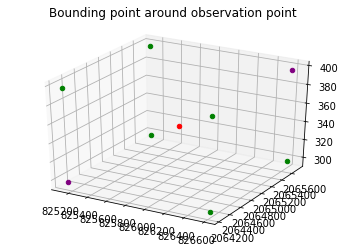

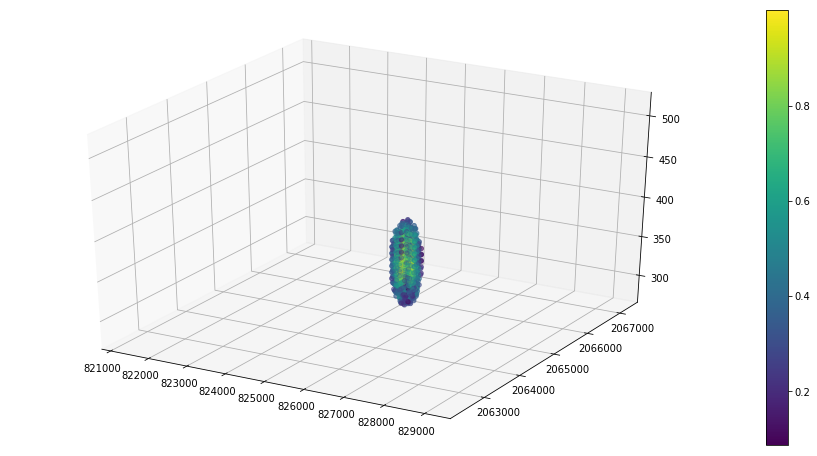

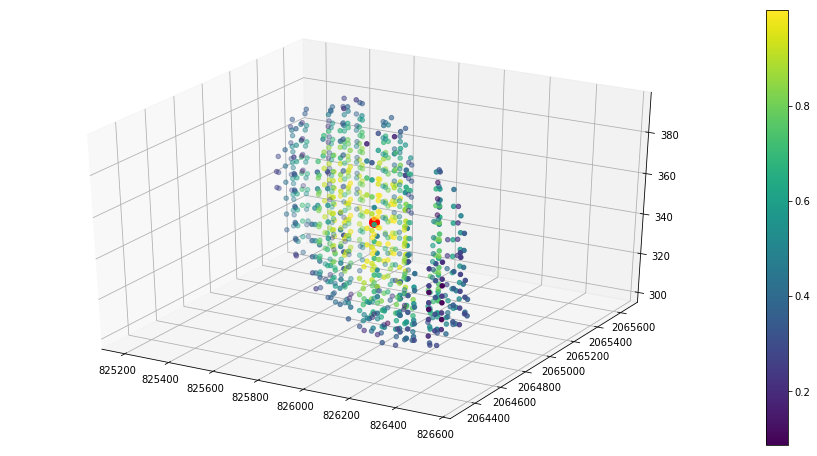

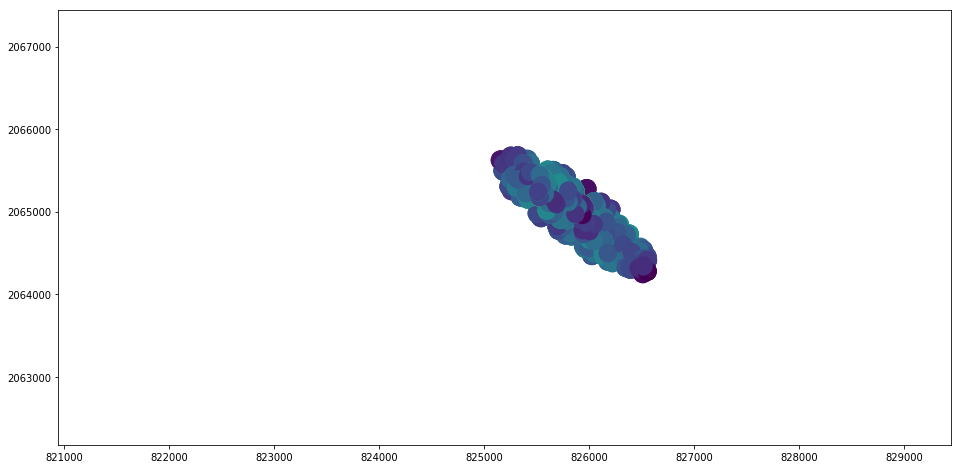

In [18]:
weighted_updating_vector(x_obs,
                         y_obs,
                         z_obs,
                         max_range,
                         med_range,
                         min_range,
                         azimuth,
                         dip,
                         vario_type,
                         sill,
                         nugget,
                         data,
                         plot=True)